In [1]:
colab_run = False
if colab_run:
    !pip -q install git+https://github.com/adalca/pystrum.git
    !pip -q install git+https://github.com/adalca/neurite.git
    !pip -q install git+https://github.com/voxelmorph/voxelmorph.git

In [2]:
model_loc = 'Models/'
csv_loc = 'CSV/'

In [3]:
# imports
import os, sys

# third party imports
import numpy as np
import tqdm
import pandas as pd
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

2023-06-05 09:54:39.544575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 09:54:40.608663: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/saumya/.conda/envs/tf/lib/
2023-06-05 09:54:40.608764: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/saumya/.conda/envs/tf/lib/
2023-06-05 09:54:40.608775: W tensorflow/compiler/tf2tensorrt/

In [4]:
# Conform test data.
def conform(x, in_shape = (256,) * 2):
    '''Resize and normalize image.'''
    x = np.float32(x)
    x = ne.utils.minmax_norm(x)
    x = ne.utils.zoom(x, zoom_factor=[o / i for o, i in zip(in_shape, x.shape)])
    return np.expand_dims(x, axis=(0, -1))


In [5]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [6]:
def vxm_data_generator_hybrid(x_data_real, x_data_synth, label_to_image, alpha_real=0.9, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """    
    # preliminary sizing
    vol_shape = x_data_real.shape[1:] # extract data shape
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    batch_size_real = int(alpha_real*batch_size)
    batch_size_synth = batch_size - batch_size_real


    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1_real = np.random.randint(0, x_data_real.shape[0], size=batch_size_real)
        moving_images_real = x_data_real[idx1_real, ..., np.newaxis]
        idx2_real = np.random.randint(0, x_data_real.shape[0], size=batch_size_real)
        fixed_images_real = x_data_real[idx2_real, ..., np.newaxis]



        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1_synth = np.random.randint(0, x_data_synth.shape[0], size=batch_size_synth)
        moving_images_synth = x_data_synth[idx1_synth, ..., np.newaxis]
        idx2_synth = np.random.randint(0, x_data_synth.shape[0], size=batch_size_synth)
        fixed_images_synth = x_data_synth[idx2_synth, ..., np.newaxis]

        moving_images = np.concatenate([moving_images_real, label_to_image(moving_images_synth)], axis=0)
        fixed_images = np.concatenate([fixed_images_real, label_to_image(fixed_images_synth)], axis=0)

        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [7]:
def vxm_data_generator_real(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

def vxm_data_generator_synth(x_data, label_to_image, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = label_to_image(x_data[idx1, ..., np.newaxis])
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = label_to_image(x_data[idx2, ..., np.newaxis])
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [8]:
class SynthLabels():
    def __init__(self, num_label=16, num_maps=250):
        # Input shapes.
        self.in_shape = (256,) * 2
        self.num_dim = len(self.in_shape)
        self.num_label = num_label
        self.num_maps = num_maps
        gen_arg = dict(
            in_shape=self.in_shape,
            in_label_list=np.arange(16),
            warp_std=3,
            warp_res=(8, 16, 32),
        )
        self.gen_model = ne.models.labels_to_image(**gen_arg, id=1)

    def label_maps(self):
        # Shape generation.
        self.label_maps = []
        self.label_maps = np.zeros((self.num_maps, 256, 256))
        for i in tqdm.tqdm(range(self.num_maps)):
            # Draw image and warp.
            im = ne.utils.augment.draw_perlin(
                out_shape=(*self.in_shape, self.num_label),
                scales=(32, 64), max_std=1,
            )
            warp = ne.utils.augment.draw_perlin(
                out_shape=(*self.in_shape, self.num_label, self.num_dim),
                scales=(16, 32, 64), max_std=16,
            )
            # Transform and create label map.
            im = vxm.utils.transform(im, warp)
            lab = tf.argmax(im, axis=-1)
            self.label_maps[i] = np.uint8(lab)
        return self.label_maps
    
    
    def label_to_image(self, sample):
        return self.gen_model.predict(sample, verbose=0)[0]

In [9]:
#Loading the dataset
images = ne.py.data.load_dataset('2D-OASIS-TUTORIAL')
conformed_images = [conform(img) for img in images]
#label_maps_real = [(img*15).astype('int').reshape(256, 256) for img in conformed_images]
label_maps_real = [img.reshape(256, 256) for img in conformed_images]


# Visualizing the dataset.
num_row = 2
per_row = 5
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(label_maps_real[i:i + per_row], cmaps=['gray'], do_colorbars=True)

2023-06-05 09:54:42.779697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 09:54:42.786521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 09:54:42.786756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 09:54:42.787334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


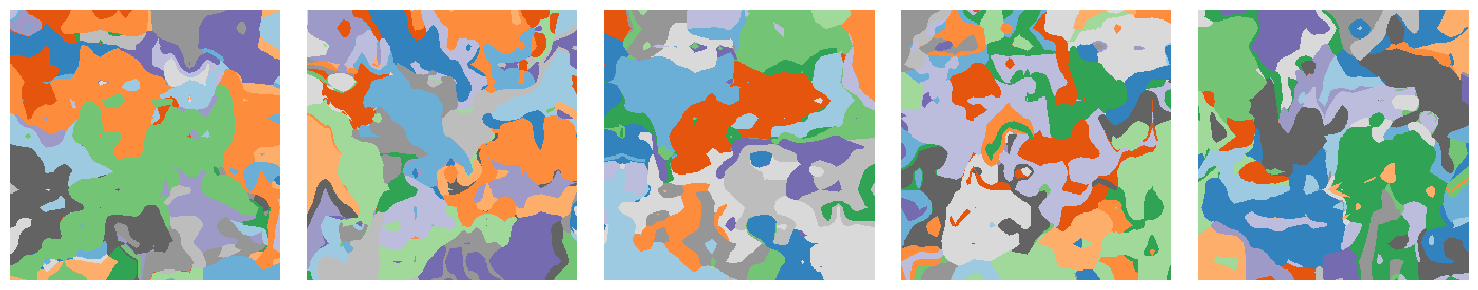

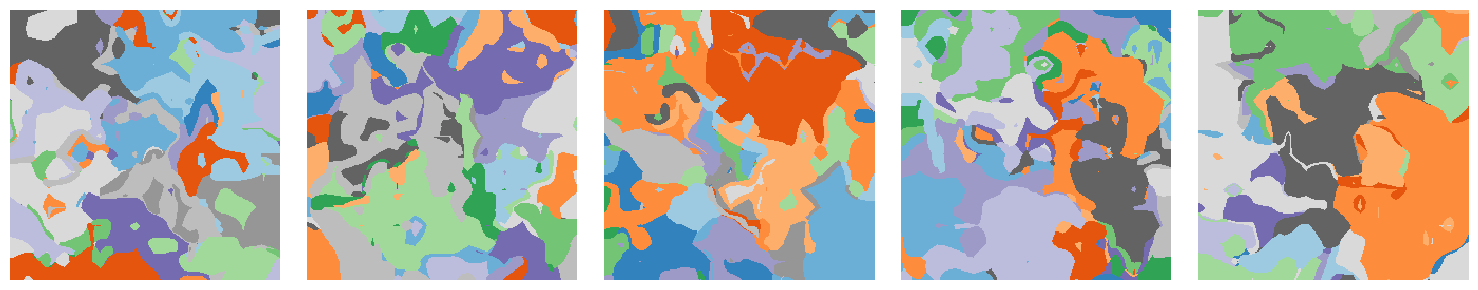

In [ ]:
if os.path.exists('Synthetic_data.npy'):
    SynthIm = SynthLabels()
    label_maps_synth = np.load('Synthetic_data.npy')
    SynthIm.label_maps = label_maps_synth
else:
    SynthIm = SynthLabels()
    label_maps_synth = SynthIm.label_maps()
    np.save('Synthetic_data.npy', label_maps_synth)

# Visualize shapes.
num_row = 2
per_row = 5
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(list(label_maps_synth[i:i + per_row]), cmaps=['tab20c'])

In [ ]:
class VxmTest():
    def __init__(self, ndim = 2, unet_input_features = 2):
        self.ndim = ndim
        self.unet_input_features = unet_input_features
    #CNN model
        # configure unet input shape (concatenation of moving and fixed images)
        self.vol_shape = real_train.shape[1:]
        # configure unet features 
        self.nb_features = [
            [32, 32, 32, 32],         # encoder features
            [32, 32, 32, 32, 32, 16]  # decoder features
        ]
        
        
    def CNNvxm(self, train_gen=None, val_generator=None):
        self.vxm_model = vxm.networks.VxmDense(self.vol_shape, nb_unet_features=None, int_steps=0)
        self.losses = ['mse', vxm.losses.Grad('l2').loss]
        self.loss_weights = [1, 0.01]
        self.vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=self.losses, loss_weights=self.loss_weights)
        

        self.train_generator = train_gen
        self.val_generator = val_generator

        self.in_sample, self.out_sample = next(self.train_generator)
        def Visual():
            # visualize
            images = [img[0, :, :, 0] for img in self.in_sample + self.out_sample]
            titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
            ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);
        Visual()
        
    def train(self, total_epo, steps_per_epoch=100):
        self.hist = self.vxm_model.fit(self.train_generator, epochs=total_epo,
                                       steps_per_epoch=100, verbose=0,
                                       callbacks=[TqdmCallback(verbose=1)],
                                       validation_data=self.val_generator,
                                       validation_steps = 100);
        plot_history(self.hist)
        
    def RegPred(self, val_input):
        self.val_pred = self.vxm_model.predict(val_input)
        #visualise
        def Visual():
            images = [img[0, :, :, 0] for img in val_input + self.val_pred] 
            titles = ['moving', 'fixed', 'moved', 'flow']
            ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);
        Visual()
        return self.val_pred

In [ ]:
#Fixing data + spliting

#conversion of labels in range of [0,1]
label_maps_real = np.array(label_maps_real)
label_maps_synth = np.array(label_maps_synth)
#label_maps_real = label_maps_real.astype('float')/15
#label_maps_synth = label_maps_synth.astype('float')/15
#label_maps_hy = np.zeros((250, 256, 256))
#label_maps_hy[::2] = [i for i in label_maps_real[:125, ...]]
#label_maps_hy[1::2] = [i for i in label_maps_synth[:125, ...]]
#label_maps_hy = np.array(label_maps_hy)

#data split 
Data_split_train = 250
real_train = label_maps_real[:250, ...]
# few_shot_train = label_maps_real[:50, ...]
test_val_no = 82
real_val = label_maps_real[250:332, ...]
real_test = label_maps_real[-82:, ...]

In [ ]:
# if colab_run:
#     train_no = 100
#     batch_size = 8
# else:
#     train_no = 2000
#     batch_size = 32

In [ ]:
train_no = 150
no_of_rounds = 10
batch_size = 5
alpha_real = 0.9

In [ ]:
# create the few shot data generator
# few_generator = vxm_data_generator_real(real_train, batch_size = 8)
# few_input, _ = next(few_generator)

# create the training data generator
train_generator = vxm_data_generator_real(real_train, batch_size = batch_size)
train_input, _ = next(train_generator)

# create the validation data generator
val_generator = vxm_data_generator_real(real_val, batch_size = batch_size)
val_input, _ = next(val_generator)

# create synthetic data generator
synth_generator = vxm_data_generator_synth(label_maps_synth, SynthIm.label_to_image, batch_size=batch_size)
synth_input, _ = next(synth_generator)

#example of the hybrid data generator
hybrid_generator = vxm_data_generator_hybrid(real_train, label_maps_synth, SynthIm.label_to_image, alpha_real=alpha_real, batch_size=batch_size)
hybrid_input, _ = next(hybrid_generator)

2023-06-05 09:53:00.369716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-06-05 09:53:02.869621: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-05 09:53:02.871017: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-05 09:53:02.871042: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-05 09:53:02.871537: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-05 09:53:02.871579: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [ ]:
def plot_csv(filename):
    df = pd.read_csv(filename)
    nu = df.to_numpy()
    fh = nu.size
    plt.figure()
    plt.plot(range(1,nu.size+1), nu, '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

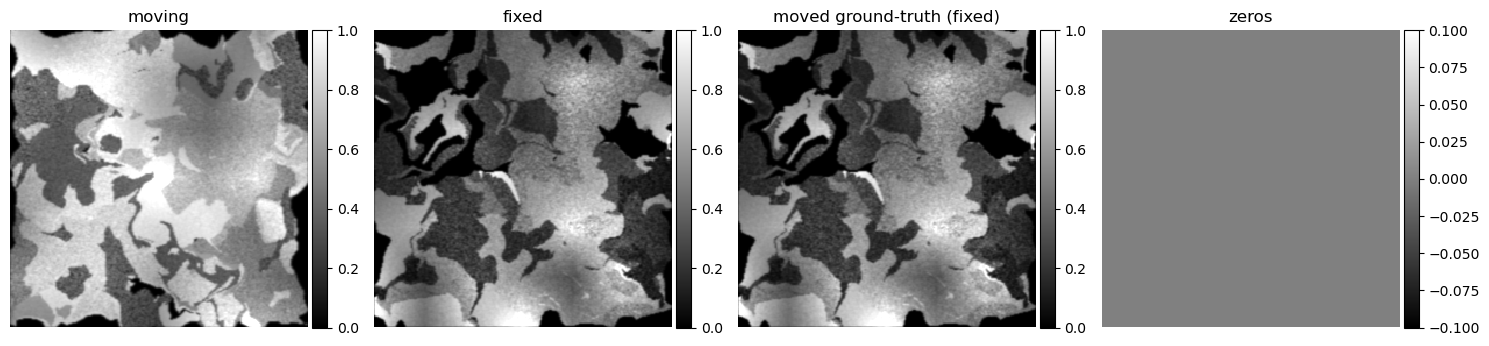

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-06-05 09:53:10.351932: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f48c855b7b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-05 09:53:10.351976: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-06-05 09:53:10.357557: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-05 09:53:10.381499: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.2
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  Fo

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_23' defined at (most recent call last):
    File "/home/saumya/.conda/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/saumya/.conda/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/saumya/.conda/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/saumya/.conda/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/saumya/.conda/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_9924/438517151.py", line 3, in <module>
      Synth.train(total_epo=train_no)
    File "/tmp/ipykernel_9924/2671847502.py", line 34, in train
      self.hist = self.vxm_model.fit(self.train_generator, epochs=total_epo,
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_23'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_23}}]] [Op:__inference_train_function_114461]

In [ ]:
Synth = VxmTest()
Synth.CNNvxm(train_gen=synth_generator, val_generator=val_generator)
Synth.train(total_epo=train_no)
Synth.vxm_model.save_weights(model_loc+'Synth_pure.h5')
b = Synth.hist.history['loss']
df = pd.DataFrame(b )
df.to_csv(csv_loc+'Synth_pure_loss.csv', index=False, header=False)
for i in range(no_of_rounds-1):
    Synth.vxm_model.load_weights(model_loc+'Synth_pure.h5')
    Synth.train(total_epo=train_no)
    Synth.vxm_model.save_weights(model_loc+'Synth_pure.h5')
    b = Synth.hist.history['loss']
    df = pd.DataFrame(b)
    df.to_csv(csv_loc+'Synth_pure_loss.csv', index=False, mode='a', header=False)

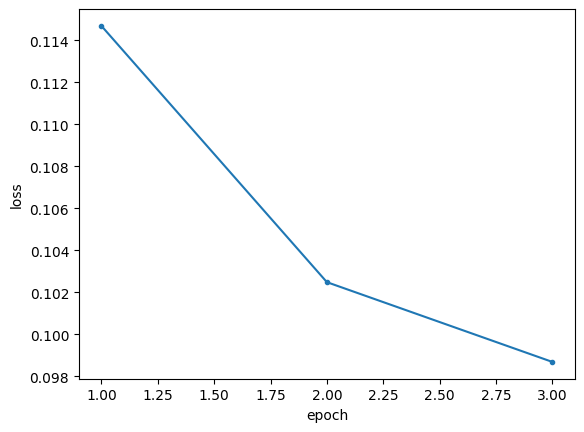

In [ ]:
plot_csv(csv_loc + 'Synth_pure_loss.csv')

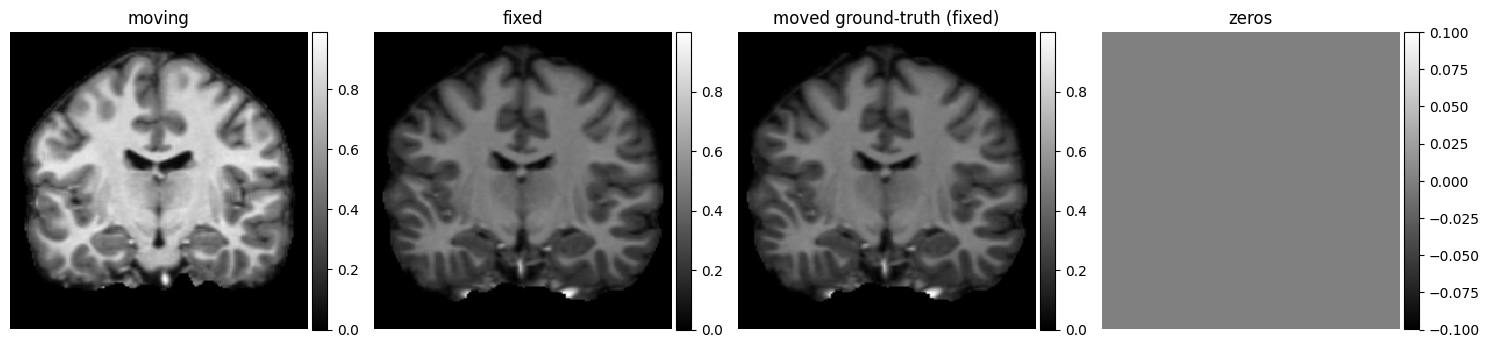

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-04-08 10:30:02.085097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-08 10:30:11.098437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


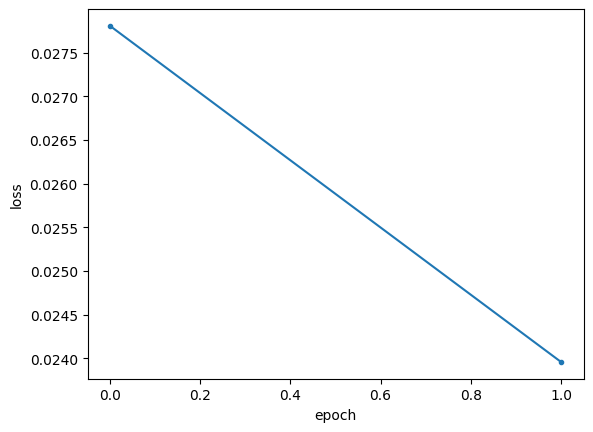

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-04-08 10:30:18.133598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-08 10:30:21.336736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


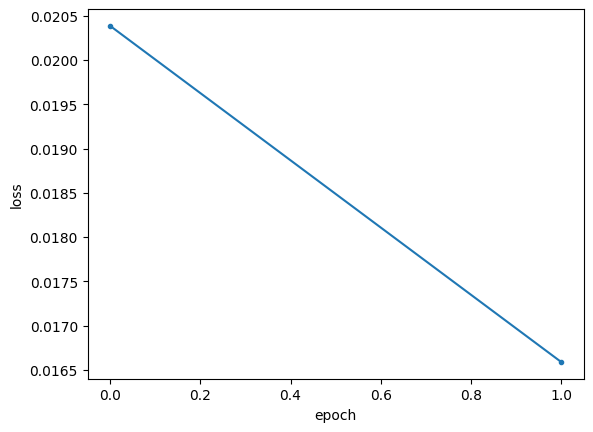

In [ ]:
Real = VxmTest()
Real.CNNvxm(train_gen=train_generator, val_generator=val_generator)
Real.train(total_epo=train_no)
Real.vxm_model.save_weights(model_loc+'Real_100steps.h5')
b = Real.hist.history['loss']
df = pd.DataFrame(b)
df.to_csv(csv_loc+'Real_loss_100steps.csv', index=False, header=False)
for i in range(no_of_rounds-1):
    Real.vxm_model.load_weights(model_loc+'Real_100steps.h5')
    Real.train(total_epo=train_no)
    Real.vxm_model.save_weights(model_loc+'Real_100steps.h5')
    b = Real.hist.history['loss']
    df = pd.DataFrame(b)
    df.to_csv(csv_loc+'Real_loss_100steps.csv', index=False, mode='a', header=False)

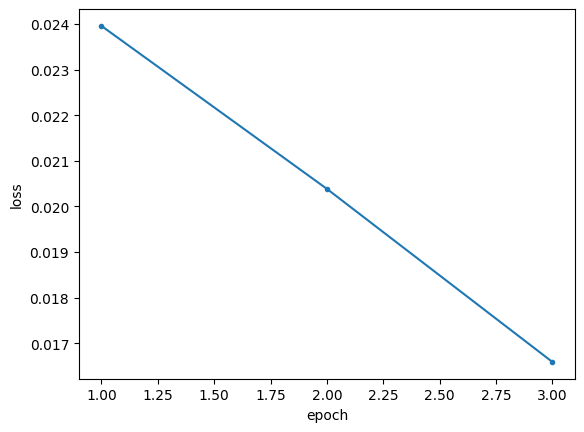

In [ ]:
plot_csv(csv_loc+'Real_loss_100steps.csv')

In [ ]:
for i in range(5, 15, 5):
    exec(f'few_shot_train_{i} = label_maps_real[:i, ...]')
# create the few shot data generator
    exec(f'few_generator_{i} = vxm_data_generator_hybrid(few_shot_train_{i}, label_maps_synth, SynthIm.label_to_image, alpha_real=alpha_real, batch_size = batch_size)')
    exec(f'train_generator_{i} = vxm_data_generator_real(few_shot_train_{i}, batch_size = batch_size)')
    exec(f'few_input_{i}, _ = next(few_generator_{i})')
    exec(f'train_input_{i}, _ = next(train_generator_{i})')

In [ ]:
goblin = '.h5'
goblin_csv = '.csv'
name = 'Hybrid_'
led = 'loss'
mode_csv = 'a'
name_loss = 'Hybrid_loss_pure'

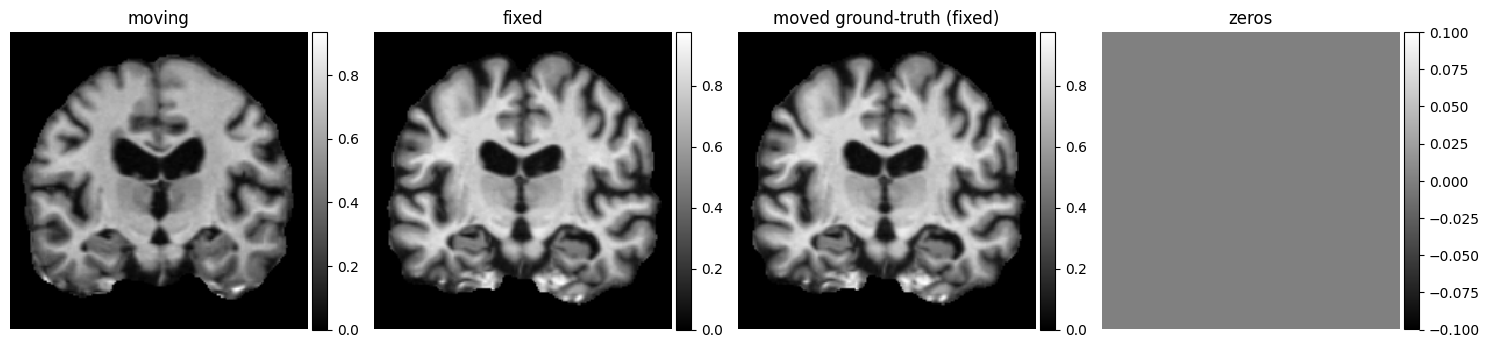

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-04-08 10:31:18.690336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-08 10:31:43.344760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


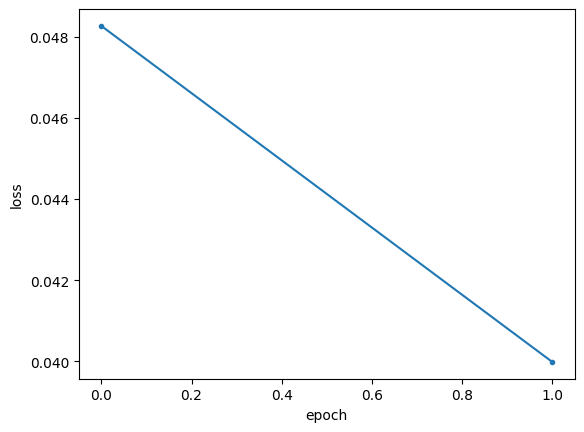

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-04-08 10:32:05.806711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-08 10:32:24.853904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


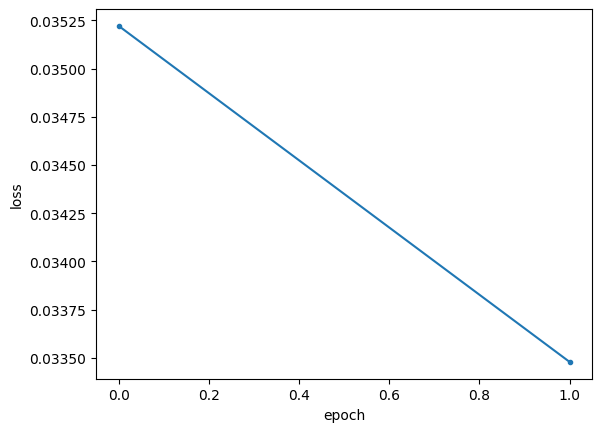

1/1 [==============================] - 0s 387ms/step


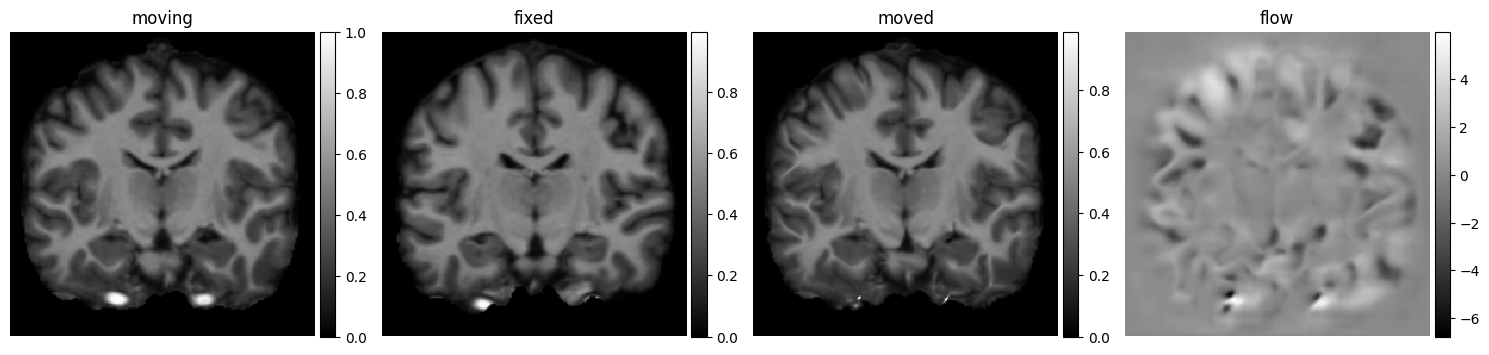

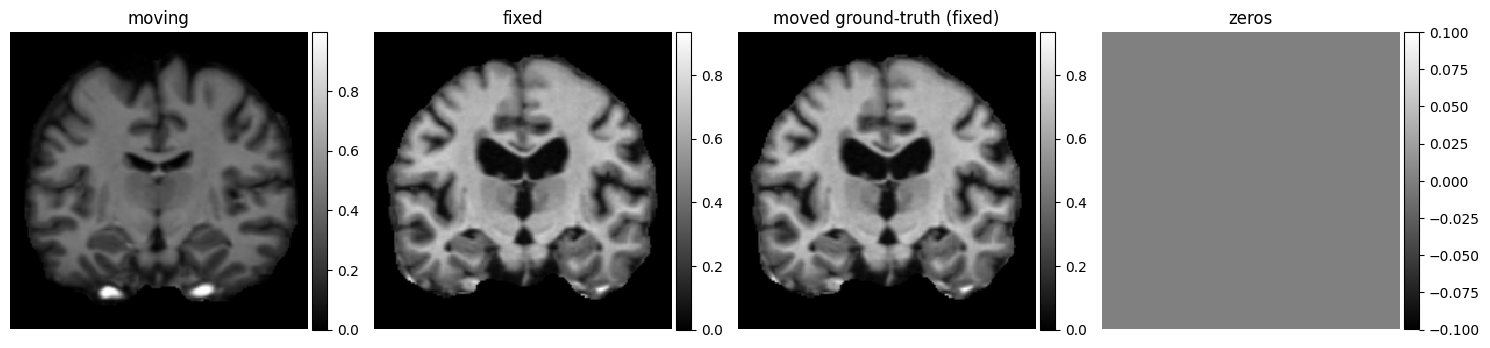

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-04-08 10:32:49.683414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-08 10:33:14.283369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


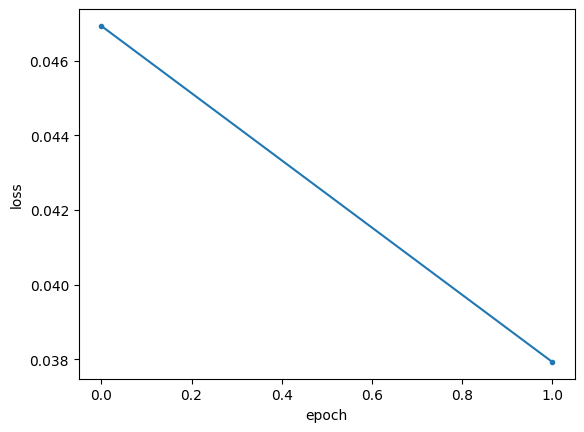

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-04-08 10:33:37.411054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-08 10:33:56.025123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


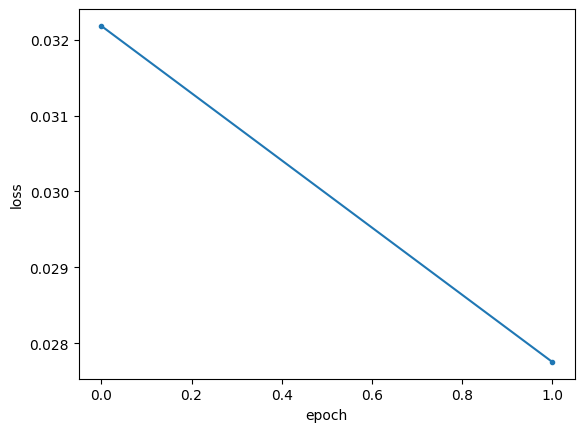

1/1 [==============================] - 0s 372ms/step


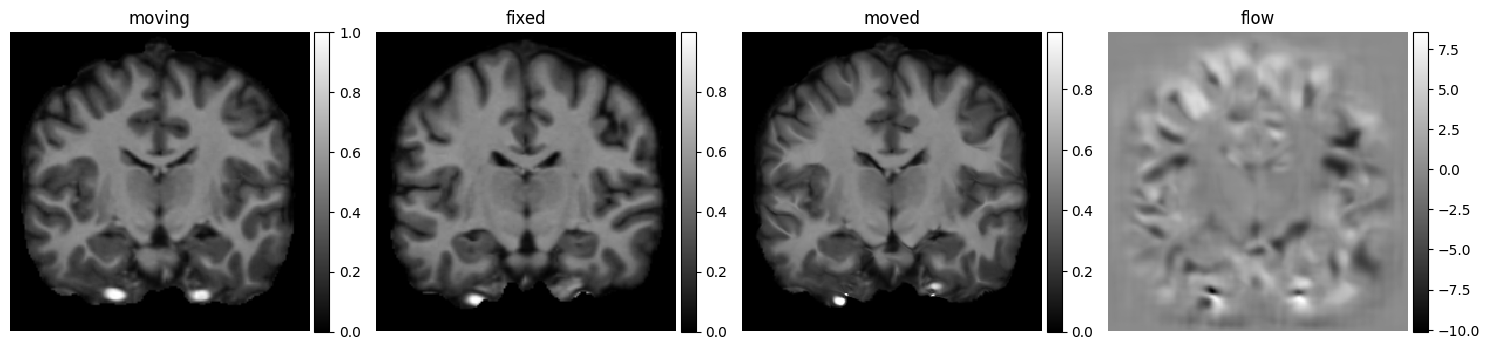

In [ ]:
#Few shots training
for k in range(5, 15, 5):
    exec(f'Fshot_{k} = VxmTest()')
    exec(f'Fshot_{k}.CNNvxm(train_gen=few_generator_{k}, val_generator=val_generator)')
    exec(f'Fshot_{k}.train(total_epo = train_no)')
    exec(f'loc = model_loc+name+str({k})+goblin')
    exec(f'Fshot_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
    exec(f'b = Fshot_{k}.hist.history[led]')
    exec(f'df = pd.DataFrame(b)')
    exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
    exec(f'df.to_csv(loc, index=False, header=False)')
    for i in range(no_of_rounds-1):
        exec(f'Fshot_{k}.vxm_model.load_weights(model_loc+name+str({k})+goblin)')
        exec(f'Fshot_{k}.train(total_epo = train_no)')
        exec(f'Fshot_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
        exec(f'b = Fshot_{k}.hist.history[led]')
        exec(f'df = pd.DataFrame(b)')
        exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
        exec(f'df.to_csv(loc, mode = mode_csv, index=False, header=False)')

    exec(f'fshot_{k} = Fshot_{k}.RegPred(val_input)[1]')

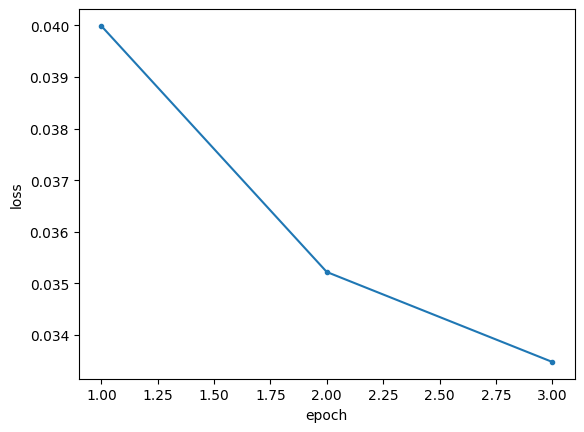

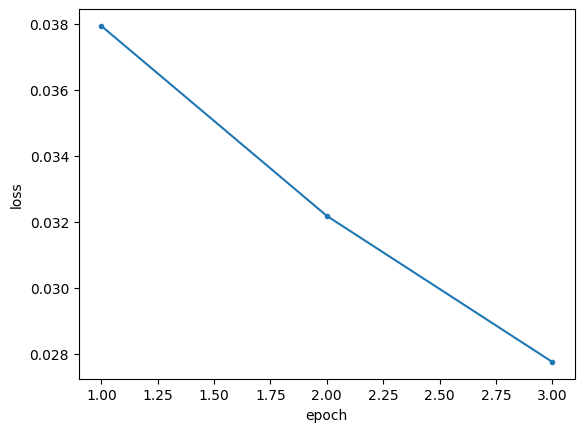

In [ ]:
for k in range(5, 15, 5):
    exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
    exec(f'plot_csv(loc)')

In [ ]:
goblin = '.h5'
goblin_csv = '.csv'
name = 'Real_Fshot_'
mode_csv = 'a'
name_loss = 'Fshot_loss_pure'

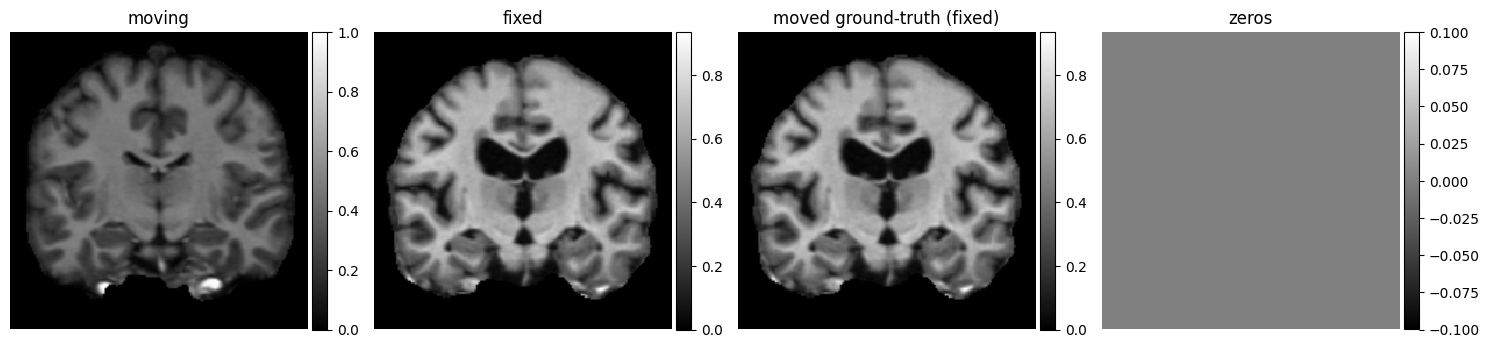

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-04-08 10:34:21.962826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-08 10:34:45.995666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


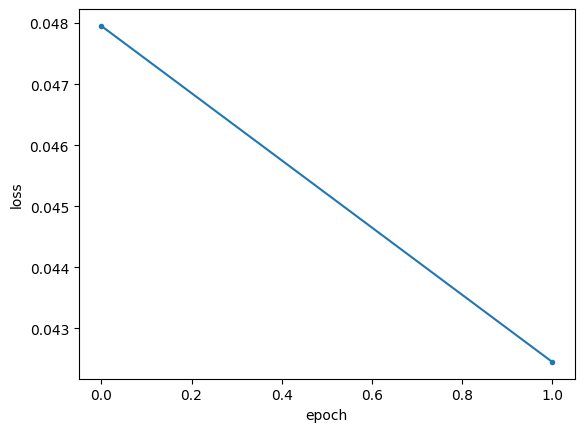

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-04-08 10:35:08.385800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-08 10:35:27.167336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


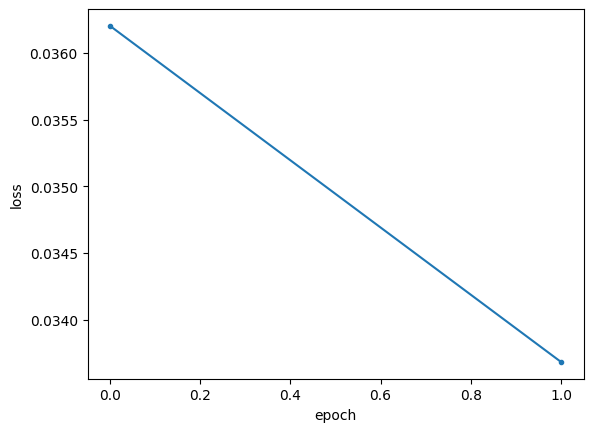

1/1 [==============================] - 0s 378ms/step


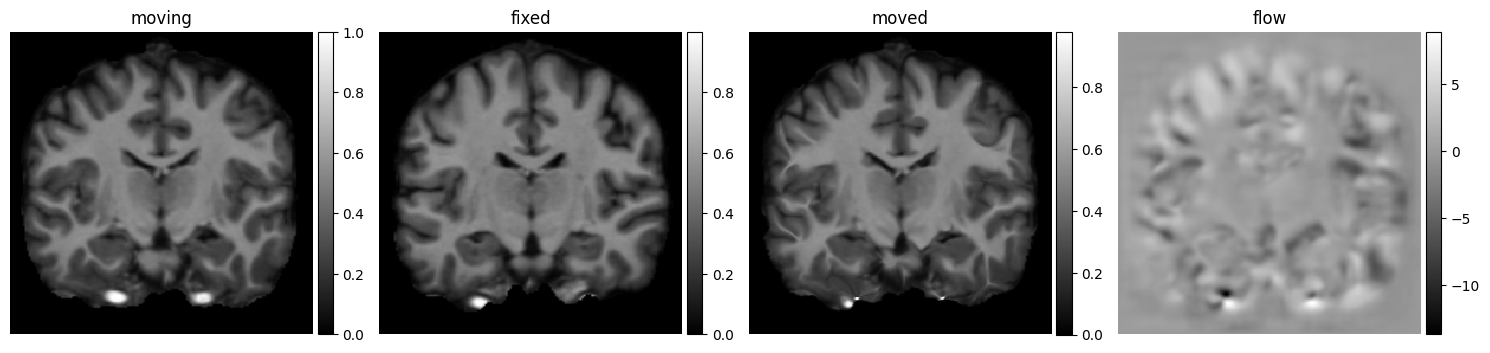

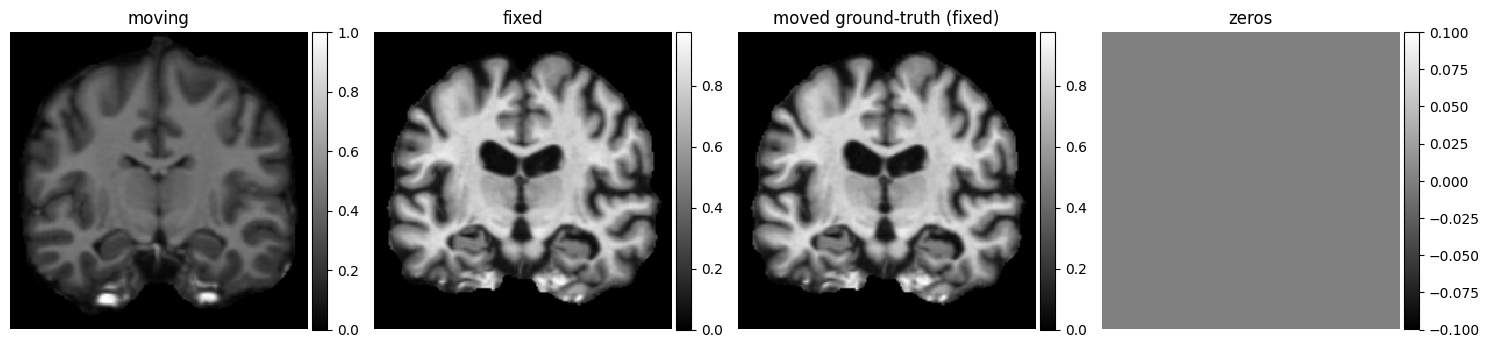

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-04-08 10:35:52.072561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-08 10:36:16.418472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


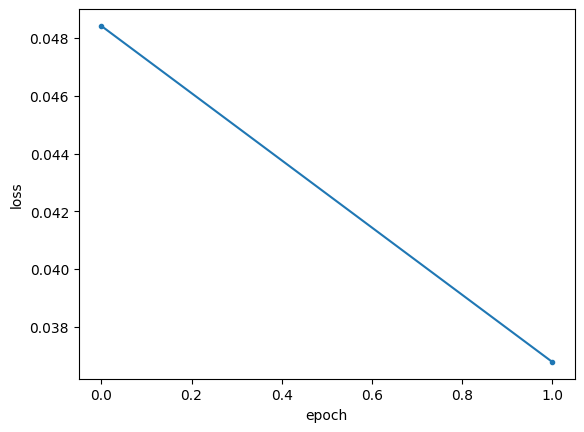

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-04-08 10:36:39.081296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-08 10:36:57.856928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


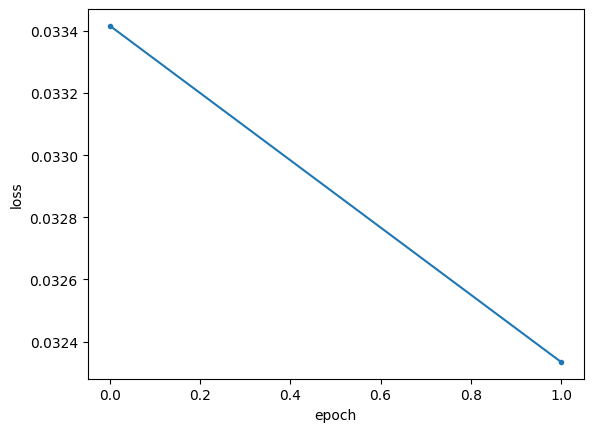

1/1 [==============================] - 0s 370ms/step


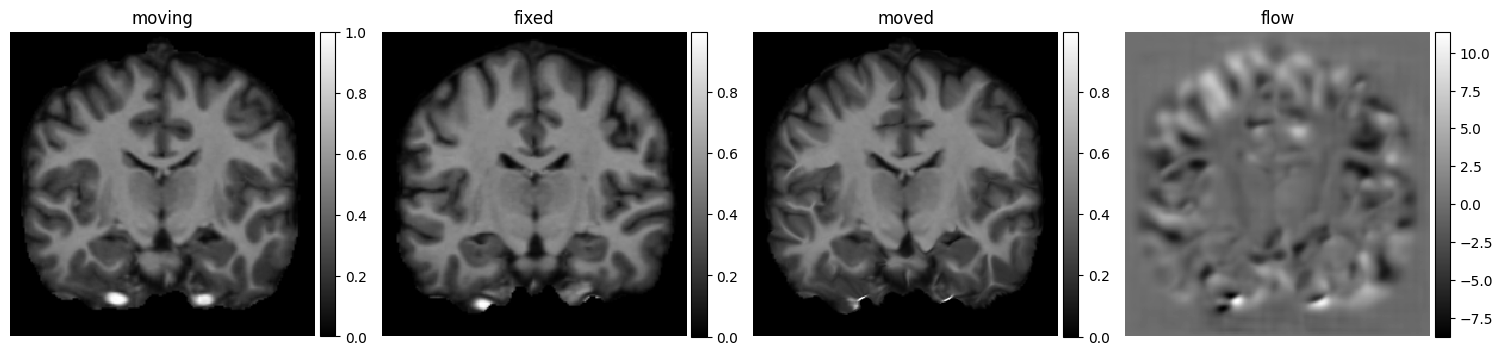

In [ ]:
#Few shots training
for k in range(5, 15, 5):
    exec(f'Hybrid_fshot_{k} = VxmTest()')
    exec(f'Hybrid_fshot_{k}.CNNvxm(train_gen=few_generator_{k}, val_generator=val_generator)')
    exec(f'Hybrid_fshot_{k}.train(total_epo = train_no)')
    exec(f'loc = model_loc+name+str({k})+goblin')
    exec(f'Hybrid_fshot_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
    exec(f'b = Hybrid_fshot_{k}.hist.history[led]')
    exec(f'df = pd.DataFrame(b)')
    exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
    exec(f'df.to_csv(loc, index=False, header=False)')
    for i in range(no_of_rounds-1):
        exec(f'Hybrid_fshot_{k}.vxm_model.load_weights(model_loc+name+str({k})+goblin)')
        exec(f'Hybrid_fshot_{k}.train(total_epo = train_no)')
        exec(f'Hybrid_fshot_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
        exec(f'b = Hybrid_fshot_{k}.hist.history[led]')
        exec(f'df = pd.DataFrame(b)')
        exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
        exec(f'df.to_csv(loc, mode = mode_csv, index=False, header=False)')

    exec(f'Hybrid_fshot_{k} = Hybrid_fshot_{k}.RegPred(val_input)[1]')

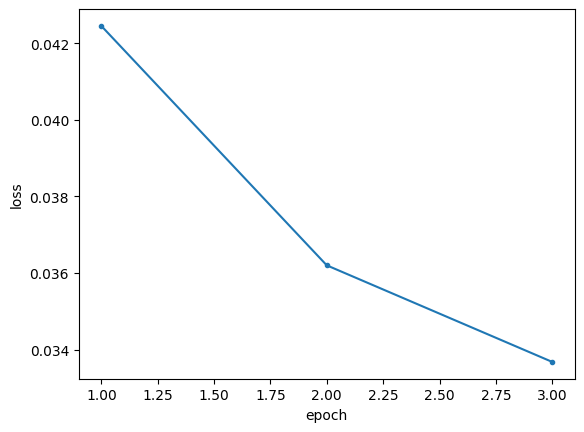

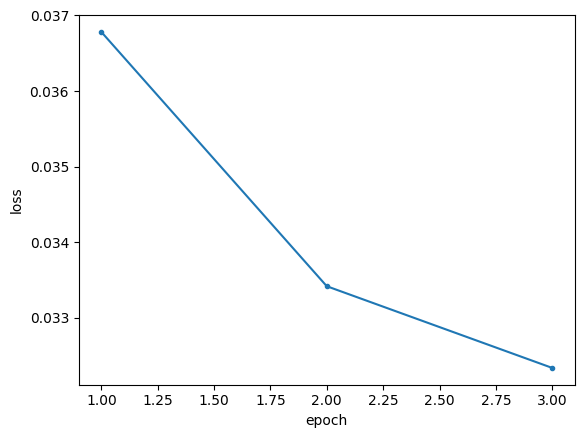

In [ ]:
for k in range(5, 15, 5):
    exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
    exec(f'plot_csv(loc)')

In [ ]:
# goblin = '.h5'
# goblin_csv = '.csv'
# name = 'Hybr_'
# mode_csv = 'a'
# name_loss = 'Hybr_Loss_'

In [ ]:
# for k in range(0, 100, 5):
#     exec(f'Hybr_{k} = VxmTest()')
#     exec(f'hybrid_generator_{k} = vxm_data_generator_hybrid(real_train, label_maps_synth, SynthIm.label_to_image, alpha_real=k/100, batch_size=batch_size)')
#     exec(f'Hybr_{k}.CNNvxm(train_gen=hybrid_generator_{k}, val_generator=val_generator)')
#     exec(f'Hybr_{k}.train(total_epo = train_no)')
#     exec(f'Hybr_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
#     led = 'loss'
#     exec(f'b = Hybr_{k}.hist.history[led]')
#     exec(f'df = pd.DataFrame(b)')
#     exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
#     exec(f'df.to_csv(loc, index=False, header=False)')
#     for i in range(no_of_rounds-1):
#         exec(f'Hybr_{k}.vxm_model.load_weights(model_loc+name+str({k})+goblin)')
#         exec(f'Hybr_{k}.train(total_epo = train_no)')
#         exec(f'Hybr_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
#         led = 'loss'
#         exec(f'b = Hybr_{k}.hist.history[led]')
#         exec(f'df = pd.DataFrame(b)')
#         exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
#         exec(f'df.to_csv(loc, mode = mode_csv, index=False, header=False)')
#     exec(f'hybr_{k} = Hybr_{k}.RegPred(val_input)[1]')

In [ ]:
# for k in range(0, 100, 5):
#     exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
#     exec(f'plot_csv(loc)')

1/1 [==============================] - 0s 368ms/step


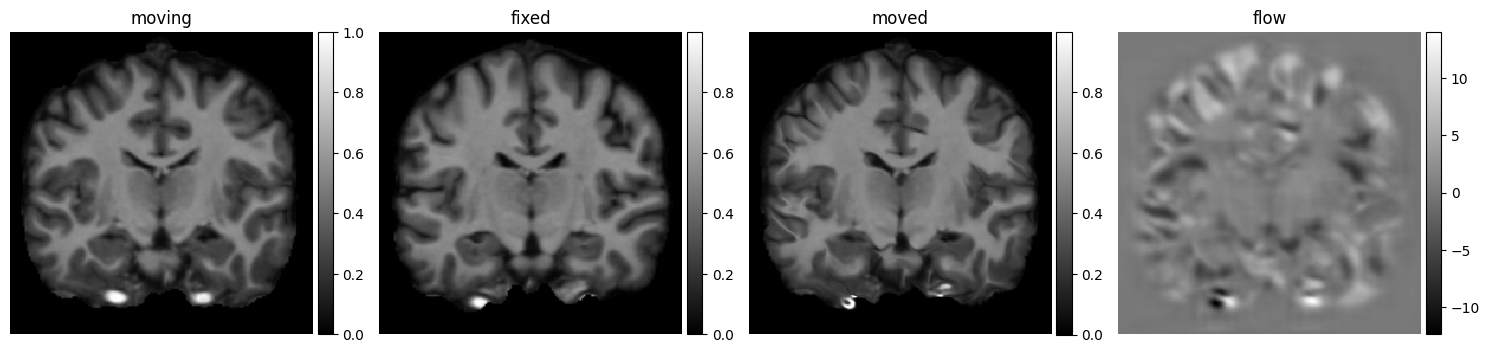

1/1 [==============================] - 0s 356ms/step


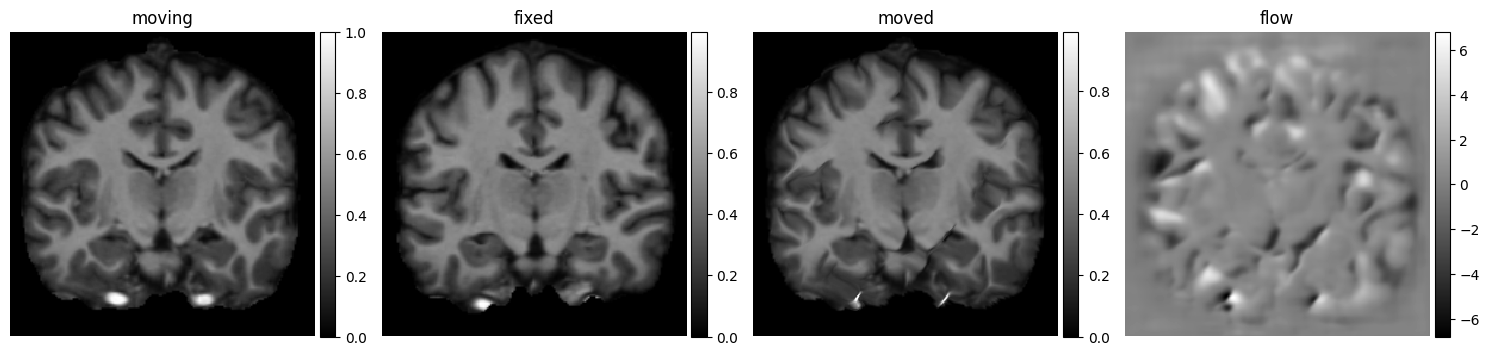

In [ ]:
real = Real.RegPred(val_input)[1]
synth = Synth.RegPred(val_input)[1]

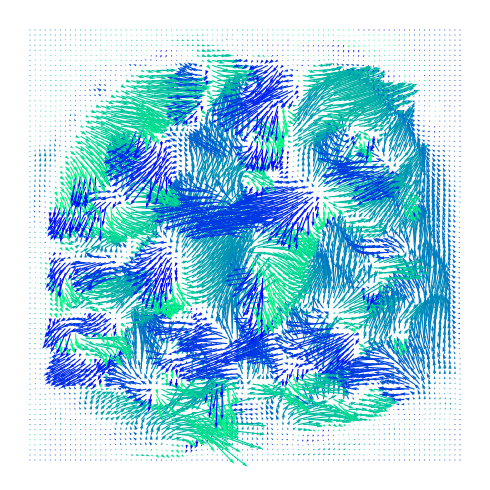

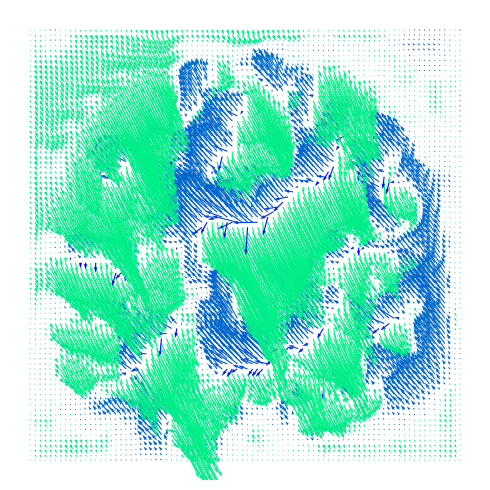

In [ ]:
ne.plot.flow([real[1].squeeze()[::3,::3]], width=5);
ne.plot.flow([synth[1].squeeze()[::3,::3]], width=5);

In [ ]:
# for k in range(0, 100, 5):
#     exec(f'ne.plot.flow([hybr_{k}[1].squeeze()],titles=k, width=5);')

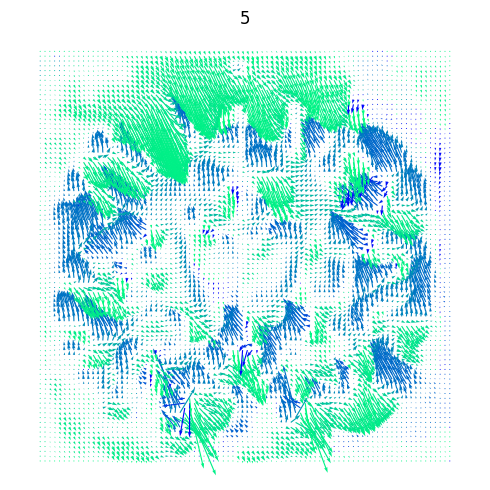

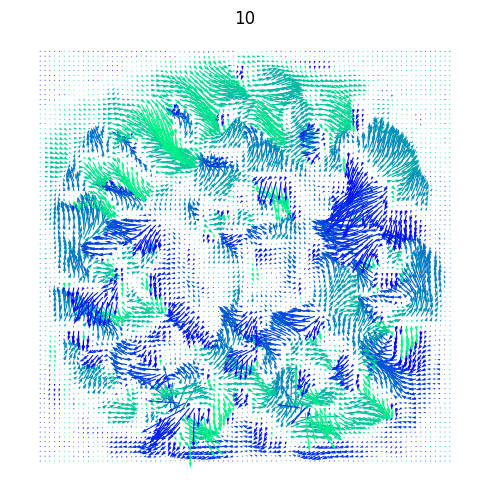

In [ ]:
for k in range(5, 15, 5):
    exec(f'ne.plot.flow([fshot_{k}[0].squeeze()[::3, ::3]],titles=k, width=5);')

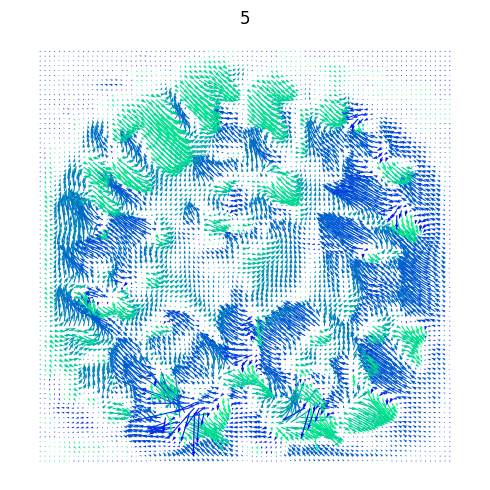

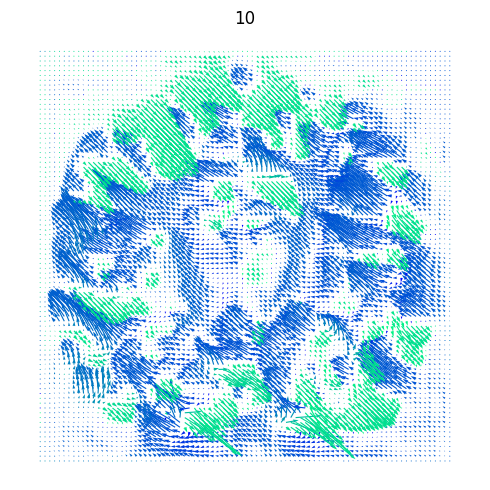

In [ ]:
for k in range(5, 15, 5):
    exec(f'ne.plot.flow([Hybrid_fshot_{k}[0].squeeze()[::3, ::3]],titles=k, width=5);')